<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Multimodal/FastVLM_apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

In [2]:
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
from pprint import pprint

In [3]:
# Constants
model_name = "apple/FastVLM-1.5B"
floats = torch.float16 if torch.cuda.is_available() else torch.float32

In [4]:
class AppleModel:
  def __init__(self, model_name, img_token_idx=-200):

    self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    self.model = AutoModelForCausalLM.from_pretrained(model_name,
                                                      torch_dtype=floats,
                                                      device_map="auto",
                                                      trust_remote_code=True)
    self.img_token_idx = img_token_idx

  def tokenize_around_img(self, pre, post):
    pre_ids  = self.tokenizer(pre,  return_tensors="pt", add_special_tokens=False).input_ids
    post_ids = self.tokenizer(post, return_tensors="pt", add_special_tokens=False).input_ids
    return pre_ids, post_ids

  def build_chat(self, text):
    messages = [{"role": "user", "content": f"<image>\n{text}"}]

    rendered = self.tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    prepost_idxs = self.tokenize_around_img(*rendered.split("<image>", 1))
    return prepost_idxs

  def get_model_args(self, pre_idx, post_idx):
    img_token = torch.tensor([[self.img_token_idx]], dtype=pre_idx.dtype)
    input_idx = torch.cat([pre_idx, img_token, post_idx], dim=1).to(self.model.device)
    attention_mask = torch.ones_like(input_idx, device=self.model.device)
    return img_token, input_idx, attention_mask

  def generate(self, input_idx, attention_mask, pxls):
    with torch.no_grad():
      out = self.model.generate(inputs=input_idx,
                                attention_mask=attention_mask,
                                images=pxls,
                                max_new_tokens=128)
    return out[0]

  def predict(self, img, text="Describe this image in detail"):
    pre_idx, post_idx = self.build_chat(text)
    img_token, input_idx, attention_mask = self.get_model_args(pre_idx, post_idx)

    pxls = self.model.get_vision_tower().image_processor(images=img, return_tensors="pt")["pixel_values"]
    pxls = pxls.to(self.model.device, dtype=self.model.dtype)

    result = self.generate(input_idx, attention_mask, pxls)
    decoded_result = self.tokenizer.decode(result, skip_special_token=True)
    return decoded_result

In [5]:
model = AppleModel(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

llava_qwen.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/apple/FastVLM-1.5B:
- llava_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/100 [00:00<?, ?B/s]

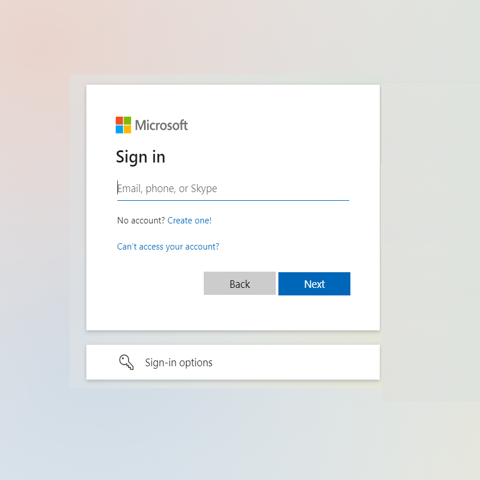

In [33]:
img = Image.open("microsoft_img.png").convert("RGB")
display(img.resize((480, 480)))

In [49]:
output = model.predict(img, 'Your are an assistant to a blind person and your task is to read and tell the UI. What interactive UI elements do you see?')
pprint(output)

('The interactive UI elements visible include:\n'
 '\n'
 '- A logo that signifies the brand for login purposes.\n'
 '- A "Sign in" button is prominent.\n'
 '- A label for entering an email, phone number, or Skype identity.\n'
 '- Options for users who do not have an account ("Create one").\n'
 "- A prompt for users who can't access their account, likely indicating a "
 'help or support feature named "Can\'t access your account?"\n'
 '- Two buttons: "Back," which takes the user to the previous step, and '
 '"Next," which advances them through the sign-in process.\n'
 '- A "Sign in options" dropdown menu, providing the user with more')
